In [1]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.3 MB/s eta 0:00:00


In [73]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
from time import time
from scipy.stats import pearsonr
from dataclasses import dataclass
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import math
import datetime
from tqdm import tqdm
import warnings
from scipy.stats import ttest_ind

ARMA Stock Prediction
1. Get a ticker (e.g. SAP)
2. Get daily returns from ticker for training (e.g. last 30 days)

Check assumptions of ARMA
3. Check stationarity by ADF (Augmented Dickey Fuller test) 
   - no seasonality, same expectation and same variance
   - If not, PASS and take another ticker
4. Draw ACF (MA) and PACF (AR)
5. Fit model to 30 days stock return (if nothing significant -> PASS)
6. Predict tomorrow y+
7. Give 95% confidence interval (x_low, x_high)
8. If y+ is in (x_low, x_high) => +1, else => 0

Backtesting
- Dont only look at one 30 day training time
    - From yesterday, look back 30 days
        - Fit ARMA, predict today, show if prediction is in 95% CI
    - From yesterday - 1, look back 30 days 
        - again \


=> We get probability P(fit) to fit the model and P(CI inc.) of how often the ARMA model predicts correctly

- Iterate over every ticker in DAX -> Get these probabilities for every ticker
- Output 40 (dax comps) x number of days backtested (30)

In [4]:
# Get SAP ticker last 60 days
sap = yf.Ticker("SAP.DE")
sap_data = sap.history(period="60d")
print(sap_data.head(5))
print(sap_data.tail(1))
print(sap_data.shape)

                                 Open        High         Low       Close  \
Date                                                                        
2023-01-13 00:00:00+01:00  107.279999  108.000000  106.980003  107.639999   
2023-01-16 00:00:00+01:00  107.940002  107.940002  107.019997  107.419998   
2023-01-17 00:00:00+01:00  107.059998  108.279999  106.180000  107.300003   
2023-01-18 00:00:00+01:00  108.000000  109.419998  107.400002  109.000000   
2023-01-19 00:00:00+01:00  108.480003  108.599998  106.019997  106.500000   

                            Volume  Dividends  Stock Splits  
Date                                                         
2023-01-13 00:00:00+01:00  1774166        0.0           0.0  
2023-01-16 00:00:00+01:00   952506        0.0           0.0  
2023-01-17 00:00:00+01:00  1482660        0.0           0.0  
2023-01-18 00:00:00+01:00  1656208        0.0           0.0  
2023-01-19 00:00:00+01:00  2203122        0.0           0.0  
                          

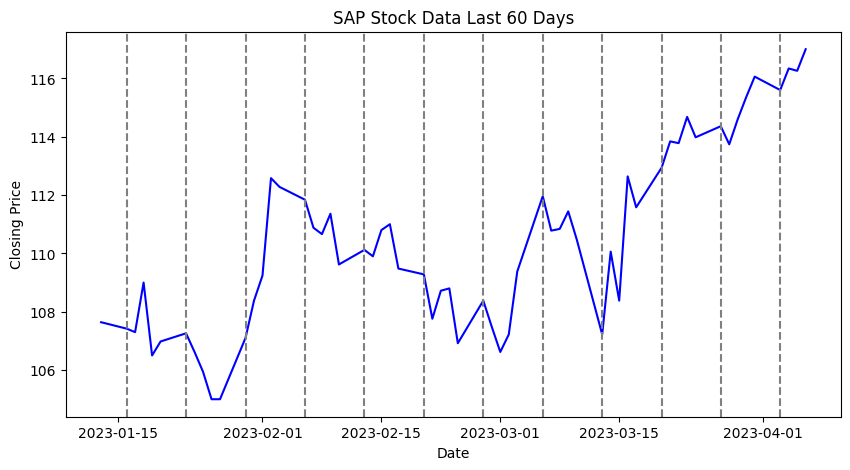

In [6]:
# Preprocessing: Delete first and last row
#sap_data = sap_data.iloc[1:-1]

# Plot the stock data
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(sap_data.index, sap_data['Close'], color='blue')

# Add a vertical line for the start of each week (Monday)
for date in sap_data.index:
    if date.weekday() == 0:
        ax.axvline(x=date, color='gray', linestyle='--')

# Set the plot title and axis labels
ax.set_title("SAP Stock Data Last 60 Days")
ax.set_xlabel("Date")
ax.set_ylabel("Closing Price")

# Show the plot
plt.show()

In [7]:
# SAP return data
sap_returns = sap_data['Close'].pct_change()

# Remove the first row of sap_returns for prediction
actual = sap_returns.iloc[-1]

# Remove first and last row
sap_returns = sap_returns.iloc[1:-1]

# Transform to series
s = pd.Series(sap_returns)

# Calculate start date by subtracting offset from current date
start_date = sap_returns.index[0].date()

# Generate range of dates with frequency of one week
dates = pd.date_range(start=start_date, periods=len(s), freq='B')

# Set dates as index of Series
s.index = dates

# Re
sap_returns = s

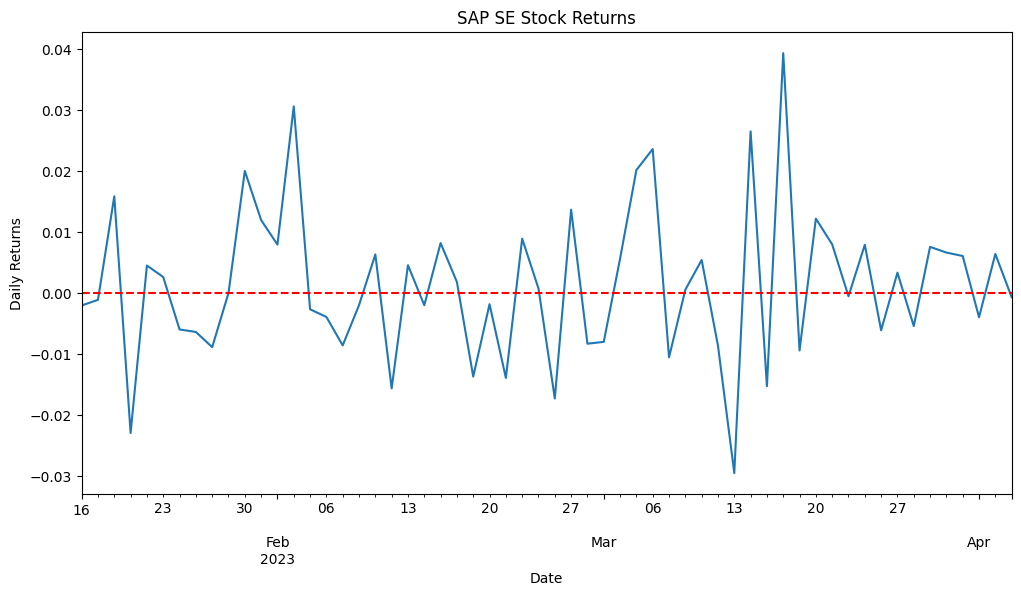

In [8]:
# Plot sap_returns
ax = sap_returns.plot(figsize=(12, 6))
ax.axhline(y=0, color='r', linestyle='--')
plt.title('SAP SE Stock Returns')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.show()

In [9]:
# Perform Augmented-Dickey-Fuller test for stationarity of returns
result = sm.tsa.stattools.adfuller(sap_returns)
if result[1] < 0.05:
    print(f"{result[1]} => stationar")
else:
    print(f"{result[1]} => not stationar")

1.8700567781076048e-16 => stationar


# Autocorrelation
The ACF measures the correlation between a time series and its lagged values, up to a specified lag order. It shows how much each lagged value is correlated with the current value of the time series. A significant correlation at a specific lag suggests that the corresponding lagged value is an important predictor of the current value, and that the time series is not a random process. \
=> Autocorrelation (ACF): ACF can help us identify the lag order for a moving average (MA) model

# Partial Autocorrelation
The PACF measures the correlation between a time series and its lagged values, after removing the effects of the intervening lags. It shows how much each lagged value is correlated with the current value of the time series, while controlling for the effects of the other lags. A significant correlation at a specific lag suggests that the corresponding lagged value is an important predictor of the current value, after accounting for the effects of the other lags. \
=> The PACF can help us identify the lag order for an autoregressive (AR) model

In [10]:
# calculate ACF values for the first 10 lags
acf_values, confint = sm.tsa.acf(sap_returns, nlags=10, fft=False, alpha=0.05)

# calculate the critical value for a two-tailed test at the 95% significance level
crit_val = 1.96 / (len(sap_returns) ** 0.5)

# create a pandas DataFrame with ACF values, confidence intervals, and significance
lag_values = range(0, 11)
acf_df = pd.DataFrame({'ACF': acf_values, 'Significant': abs(acf_values) > crit_val}, index=lag_values)

# print the DataFrame
print(acf_df)

         ACF  Significant
0   1.000000         True
1  -0.252503        False
2   0.178088        False
3  -0.078843        False
4  -0.073322        False
5  -0.037287        False
6  -0.254102        False
7   0.018539        False
8   0.093535        False
9   0.020098        False
10 -0.053308        False


In [11]:
# calculate PACF values for the first 10 lags
pacf_values, confint = sm.tsa.pacf(sap_returns, nlags=10, alpha=0.05)

# calculate the critical value for a two-tailed test at the 95% significance level
crit_val = 1.96 / (len(sap_returns) ** 0.5)

# create a pandas DataFrame with PACF values, confidence intervals, and significance
lag_values = range(0, 11)
pacf_df = pd.DataFrame({'PACF': pacf_values,'Significant': abs(pacf_values) > crit_val}, index=lag_values)

# print the DataFrame
print(pacf_df)

        PACF  Significant
0   1.000000         True
1  -0.256933        False
2   0.126805        False
3  -0.009991        False
4  -0.133690        False
5  -0.081714        False
6  -0.309522         True
7  -0.138303        False
8   0.175921        False
9   0.078439        False
10 -0.200440        False


/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


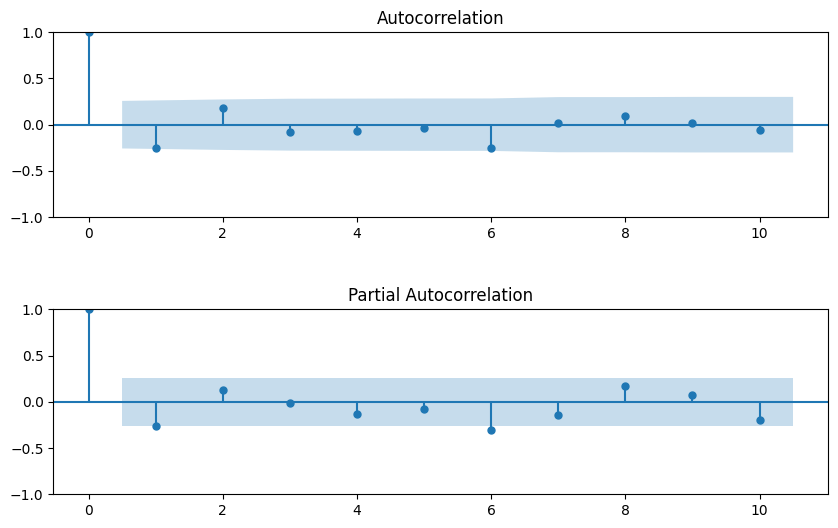

In [12]:
# Plot ACF and PACF
fig, ax = plt.subplots(nrows=2, figsize=(10, 6))
tsaplots.plot_acf(sap_returns, lags=10, ax=ax[0])
tsaplots.plot_pacf(sap_returns, lags=10, ax=ax[1])
plt.subplots_adjust(hspace=0.5)
plt.show();

In [13]:
# fit an ARMA model based on the highest significant lag of the ACF and PACF
d = 0 # ARIMA = I = 0
order = (pacf_df.index[pacf_df['Significant'] == True][-1], d,  acf_df.index[acf_df['Significant'] == True][-1])
model = ARIMA(sap_returns, order=order)
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   58
Model:                 ARIMA(6, 0, 0)   Log Likelihood                 176.721
Date:                Sat, 08 Apr 2023   AIC                           -337.443
Time:                        09:05:13   BIC                           -320.959
Sample:                    01-16-2023   HQIC                          -331.022
                         - 04-05-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.303      0.193      -0.001       0.004
ar.L1         -0.2477      0.136     -1.822      0.068      -0.514       0.019
ar.L2          0.0863      0.148      0.584      0.5

In [14]:
# Use the auto_arima function to select the best ARIMA order
ar_p_max = pacf_df.index[pacf_df['Significant'] == True][-1]
ma_q_max = acf_df.index[acf_df['Significant'] == True][-1]

# Auto Arima, checks the best possible arima model based on aic and bic
model = auto_arima(sap_returns, start_p=0, start_q=0, max_p=ar_p_max, 
                   max_q=ma_q_max, seasonal=False, trace=True)

# Print the summary of the selected model
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-340.454, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-341.731, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-340.851, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-340.941, Time=0.13 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.487 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 172.866
Date:                Sat, 08 Apr 2023   AIC                           -341.731
Time:                        09:05:17   BIC                           -337.610
Sample:                    01-16-2023   HQIC                          -340.126
                         - 04-05-2023                                         
Covariance Type:                  opg                          

In [15]:
# Get best model
best_model = model.order
print(best_model)

# Fit an ARIMA model
model = ARIMA(sap_returns, order=best_model)
results = model.fit()

# Make a prediction
alpha = 0.05
forecast = results.get_forecast(steps=1, alpha=alpha)

# Extract the predicted value and confidence intervals
prediction = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=alpha)

# Print the predicted value
print(f"Actual for {datetime.date.today()}: {actual}")
print(f"Prediction for {datetime.date.today()}: {prediction[0]}")
print(f"{1-alpha}% Confidence Interval for {datetime.date.today()}: {conf_int}")

(1, 0, 0)
Actual for 2023-04-08: 0.0063650253756439845
Prediction for 2023-04-08: 0.0019472575441418687
0.95% Confidence Interval for 2023-04-08:             lower Close  upper Close
2023-04-06    -0.021859     0.025753


In [16]:
# Check if prediction is within confidence interval
if prediction[0] >= conf_int['lower Close'][0] and prediction[0] <= conf_int['upper Close'][0]: 
  print("Prediction is within the confidence interval")
else:
  print("Prediction is outside of the confidence interval")

Prediction is within the confidence interval


**Putting the ARMA model prediction in one function**

*Description*
- ticker: Ticker from stock
- period_days: Number of days we want to use to train the model for prediction

In [17]:
def add_d_to_period(period_days: int) -> str:
    return f"{period_days}d"

In [18]:
def get_ticker(ticker: str, period_days: int):  
    
    # Get ticker for specified period
    tick = yf.Ticker(ticker)
    data = tick.history(period=add_d_to_period(period_days))

    return data

ARMA (AutoRegressive Moving Average) is a time series model that combines both autoregressive (AR) and moving average (MA) components to model the behavior of a time series. The AR component models the relationship between the current value of the time series and its past values, while the MA component models the relationship between the current value of the time series and its past forecast errors.

*Description*
- alpha: Alpha level (usually 0.05)
- lags: Number of lags we want to see for our ARMA model
- model_summary: Get a summary of best ARMA model

In [19]:
def arma(data, alpha: float, lags: int, model_summary: False):

    # Calculate returns
    returns = data['Close'].pct_change()
    # Save the last row of returns for prediction validation
    actual = returns.iloc[-1]
    # Remove first and last row
    returns = returns.iloc[1:-1]

    # Change to date format
    returns = pd.Series(returns)
    start_date = returns.index[0].date()
    dates = pd.date_range(start=start_date, periods=len(returns), freq='B')
    returns.index = dates

    # Perform Augmented-Dickey-Fuller test for stationarity of returns
    result = sm.tsa.stattools.adfuller(returns)
    if not result[1] <= alpha:
      #print(f'Not stationary')
      return ("no stationary")

    # ACF values
    acf_values = sm.tsa.acf(returns, nlags=lags, fft=False, alpha=alpha)[0]
    # calculate the critical value for a two-tailed test at the 95% significance level
    crit_val = 1.96 / (len(returns) ** 0.5)
    # create a pandas DataFrame with ACF values, confidence intervals, and significance
    lag_values = range(0, lags + 1)
    acf_df = pd.DataFrame({'ACF': acf_values, 'Significant': abs(acf_values) > crit_val}, index=lag_values) 
    
    # PACF values
    pacf_values = sm.tsa.pacf(returns, nlags=lags, alpha=alpha)[0]
    # calculate the critical value for a two-tailed test at the 95% significance level
    crit_val = 1.96 / (len(returns) ** 0.5)
    # create a pandas DataFrame with PACF values, confidence intervals, and significance
    lag_values = range(0, lags + 1)
    pacf_df = pd.DataFrame({'PACF': pacf_values,'Significant': abs(pacf_values) > crit_val}, index=lag_values)

    # if no significant lags in acf and pcf, stop
    if ((acf_df.iloc[1:]['Significant'] == False).all() == True) and ((pacf_df.iloc[1:]['Significant'] == False).all() == True):
      #print("No significant lags found in ACF and PCF")
      return ("no acf/pacf significance")

    # Use the auto_arima function to select the best ARIMA order
    ar_p_max = pacf_df.index[pacf_df['Significant'] == True][-1]
    ma_q_max = acf_df.index[acf_df['Significant'] == True][-1]

    # Auto Arima, checks the best possible arima model based on aic and bic
    model = auto_arima(returns, start_p=0, start_q=0, max_p=ar_p_max, 
                      max_q=ma_q_max, seasonal=False, trace=False, maxiter = 1000)
    
    # Print summary of final model
    if model_summary == True: 
      print(model.summary())
    
    # Fit best model
    best_model = model.order
    # Fit an ARIMA model
    model = ARIMA(returns, order=best_model)
    results = model.fit()
    forecast = results.get_forecast(steps=1, alpha=alpha)
    # Extract the predicted value and confidence intervals
    prediction = forecast.predicted_mean
    conf_int = forecast.conf_int(alpha=alpha)
    conf_lower = conf_int['lower Close'][0]
    conf_upper = conf_int['upper Close'][0]
    
    return (actual, prediction[0], conf_lower, conf_upper)

In [20]:
# Get ticker
data = get_ticker("SAP.DE", 60)

# Fit ARMA
arma(data, 0.05, 20, model_summary = True)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 172.866
Date:                Sat, 08 Apr 2023   AIC                           -341.731
Time:                        09:05:42   BIC                           -337.610
Sample:                    01-16-2023   HQIC                          -340.126
                         - 04-05-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2363      0.122     -1.939      0.052      -0.475       0.003
sigma2         0.0002   2.23e-05      6.753      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.01   Jarque-

(0.0063650253756439845,
 0.0019472575441418687,
 -0.021858945562596755,
 0.02575346065088049)

**Backtesting**

Backtesting is a process of testing a trading strategy on historical data to evaluate its performance. It involves simulating trades using past market data to assess the profitability and risk of a trading strategy before it is applied in real-time trading.

*Description*
- ticker: Ticker from stock
- period_days: Number of days we want to use to train the model for prediction
- alpha: Alpha level (usually 0.05)
- lags: Number of lags we want to see for our ARMA model
- backtest_days: Number of validation samples (like cross-validation)
- print_rounds: See actual and prediction for each backtesting round


In [59]:
def backtest(ticker: str, period_days: int, alpha: float, lags: int, 
             backtest_days: int, print_rounds: True, money: int):
  
    # Period_days has to be bigger than backtest_days 
    if period_days < backtest_days: 
      raise ValueError("backtest_days needs to be smaller than period_days")
    
    # Get ticker for specified period
    tick = yf.Ticker(ticker)
    data = tick.history(period=add_d_to_period(period_days + backtest_days))

    # Initialize values to store backtesting results
    tendency = 0
    conf = 0
    stationarity = 0
    significance = 0
    invest = 0

    # Loop over each day in the backtesting period
    for i in tqdm(range(backtest_days)):

        # Fit the ARMA model 
        result = arma(data, alpha, lags, model_summary = False)

        # Stop ARMA function
        if isinstance(result, str):
            if result == "no stationary":
              
              stationarity +=1
              # Print backtesting round
              if print_rounds == True:
                print(f"Round {i+1}: Not stationary")           
            else:
              significance +=1
              # Print backtesting round
              if print_rounds == True:
                print(f"Round {i+1}: Not significant")

        # ARMA can be fitted
        else:
            actual, prediction, lower, upper = result

            # Tendency that model predicted negative or positive correctly
            if actual * prediction > 0: 
              tendency += 1 
            
            if prediction >= lower and prediction <= upper: 
              conf += 1

            # Print backtesting round
            if print_rounds == True:
              print(f"Round {i+1}: Prediction: {round(prediction, 5)}, Actual: {round(actual, 5)}")

            # Invest
            if money != 0 and prediction > 0: 
              invest = invest + (money * actual)

        # Delete last row from data
        data = data.iloc[:-1]

    # Calculate backtesting rates
    tendency_rate = tendency/backtest_days
    conf_rate = conf/backtest_days
    stationarity_rate = stationarity/backtest_days
    significance_rate = significance/backtest_days

    # Build DataFrame from rates
    df = {
        'Tendency Rate': [tendency_rate],
        'Confidence Rate': [conf_rate],
        'Stationarity Rate': [stationarity_rate],
        'Significance Rate': [significance_rate],
        'Return on Invest': [invest]
    }

    # Return the backtesting results
    return (pd.DataFrame(df))

Backtesting SAP stock for 10 days with a training set of 60 days on a 5% significance level. We find a positive Tendency Rate of 0.6 and we can see that when we would have invested 100 dollar on every 10 days, we would have made a return of appr. 2.8 dollar in 10 days

In [60]:
# Ignore warnings
warnings.filterwarnings('ignore')

backtest("SAP.DE", 60, 0.05, 15, 10, print_rounds = True, money = 100)

 10%|█         | 1/10 [00:01<00:15,  1.73s/it]

Round 1: Prediction: 0.00409, Actual: 0.00637


 20%|██        | 2/10 [00:03<00:14,  1.82s/it]

Round 2: Prediction: 0.00103, Actual: -0.00069


 30%|███       | 3/10 [00:05<00:11,  1.66s/it]

Round 3: Prediction: 0.00447, Actual: 0.0064


 40%|████      | 4/10 [00:06<00:09,  1.65s/it]

Round 4: Prediction: 0.0033, Actual: -0.00396


 50%|█████     | 5/10 [00:08<00:07,  1.60s/it]

Round 5: Prediction: 0.00336, Actual: 0.00607


 60%|██████    | 6/10 [00:10<00:07,  1.89s/it]

Round 6: Prediction: 0.00049, Actual: 0.00663


 70%|███████   | 7/10 [00:12<00:05,  1.71s/it]

Round 7: Prediction: 0.00275, Actual: 0.00756


 80%|████████  | 8/10 [00:12<00:02,  1.42s/it]

Round 8: Prediction: 0.00289, Actual: -0.00542


100%|██████████| 10/10 [00:13<00:00,  1.37s/it]

Round 9: Prediction: 0.00288, Actual: 0.00333
Round 10: Prediction: 0.00303, Actual: -0.0061


,Tendency Rate,Confidence Rate,Stationarity Rate,Significance Rate,Return on Invest
0,0.6,1.0,0.0,0.0,2.018465


**Testing on DAX**

List of DAX30 according to Yahoo Finance (8th April 2023)

In [81]:
dax_tickers = [
    "P911.DE",  # Dr. Ing. h.c. F. Porsche AG
    "CON.DE",  # Continental Aktiengesellschaft
    "BAS.DE",  # BASF SE
    "ADS.DE",  # adidas AG
    "DTG.DE",  # Daimler Truck Holding AG
    "ENR.DE",  # Siemens Energy AG
    "HEI.DE",  # HeidelbergCement AG
    "BMW.DE",  # Bayerische Motoren Werke Aktiengesellschaft
    "VOW3.DE",  # Volkswagen AG
    "IFX.DE",  # Infineon Technologies AG
    "1COV.DE",  # Covestro AG
    "EOAN.DE",  # E.ON SE
    "SHL.DE",  # Siemens Healthineers AG
    "ZAL.DE",  # Zalando SE
    "MRK.DE",  # MERCK Kommanditgesellschaft auf Aktien
    "DPW.DE",  # Deutsche Post AG
    "DTE.DE",  # Deutsche Telekom AG
    "BEI.DE",  # Beiersdorf Aktiengesellschaft
    "DB1.DE",  # Deutsche Boerse AG
    "AIR.DE",  # Airbus SE
    "ALV.DE",  # Allianz SE
    "MTX.DE",  # MTU Aero Engines AG
    "DBK.DE",  # Deutsche Bank AG
    "BAYN.DE",  # Bayer Aktiengesellschaft
    "HNR1.DE",  # Hannover Rück SE
    "SIE.DE",  # Siemens Aktiengesellschaft
    "RWE.DE",  # RWE AG
    "FRE.DE",  # Fresenius SE & Co. KGaA
    "SY1.DE",  # Symrise AG
    "VNA.DE",  # Vonovia SE
]

Applying backtesting function to the DAX list. Here, we perform backtesting for the past 30 days based on the 100 days before (training data) with 30 lags and 5% significance level.

In [82]:
# Ignore warnings
warnings.filterwarnings('ignore')

# lists
names = []
results = []

for ticker in dax_tickers:
    new_row = backtest(ticker, 100, 0.05, 30, 30, print_rounds = False, money = 100)
    results.append(new_row)

# Convert the list of DataFrames into a single DataFrame
combined_df = pd.concat(results, ignore_index=True)

# Add the names column to the combined DataFrame
combined_df.insert(0, 'Name', dax_tickers)

100%|██████████| 30/30 [01:09<00:00,  2.31s/it]


*Description* 
- Tendency Rate = Describes in how many cases the model predicted if a return will be positive or negative
- Confidence Rate = Describes in how many cases the prediction was in a 95% Confidence Interval
- Stationary Rate = Describes in how many cases the ARMA model could not be fitted because the returns are not stationary 
- Significance Rate = Describes in how many cases the ARMA model does not find a significant lag and thus cannot be fitted
- Return on Invest = Calculates the return on invest based on the predictions of the model for each stock

In [83]:
# Results
combined_df

,Name,Tendency Rate,Confidence Rate,Stationarity Rate,Significance Rate,Return on Invest
0,P911.DE,0.266667,0.666667,0.000000,0.333333,1.975983
1,CON.DE,0.466667,1.000000,0.000000,0.000000,-3.653467
2,BAS.DE,0.100000,0.433333,0.000000,0.566667,-16.817689
3,ADS.DE,0.633333,1.000000,0.000000,0.000000,17.008725
4,DTG.DE,0.433333,1.000000,0.000000,0.000000,-14.951867
5,ENR.DE,0.466667,0.833333,0.000000,0.166667,-1.236411
6,HEI.DE,0.366667,1.000000,0.000000,0.000000,-6.145808
7,BMW.DE,0.433333,0.900000,0.000000,0.100000,-2.828085
8,VOW3.DE,0.400000,1.000000,0.000000,0.000000,-5.686293
9,IFX.DE,0.500000,1.000000,0.000000,0.000000,2.481055


Looking at the results, the tendency rate lies below 0.5 which is worth than choosing a outcome of a flipping coin to predict the next day

In [84]:
# Getting mean values from DAX
mean_values = combined_df.mean()

print(mean_values)

Tendency Rate        0.462222
Confidence Rate      0.891111
Stationarity Rate    0.021111
Significance Rate    0.087778
Return on Invest    -0.960608
dtype: float64


In [85]:
filtered_df = combined_df[combined_df['Confidence Rate'] == 1]
filtered_df

,Name,Tendency Rate,Confidence Rate,Stationarity Rate,Significance Rate,Return on Invest
1,CON.DE,0.466667,1.0,0.0,0.0,-3.653467
3,ADS.DE,0.633333,1.0,0.0,0.0,17.008725
4,DTG.DE,0.433333,1.0,0.0,0.0,-14.951867
6,HEI.DE,0.366667,1.0,0.0,0.0,-6.145808
8,VOW3.DE,0.400000,1.0,0.0,0.0,-5.686293
9,IFX.DE,0.500000,1.0,0.0,0.0,2.481055
11,EOAN.DE,0.633333,1.0,0.0,0.0,12.312045
12,SHL.DE,0.533333,1.0,0.0,0.0,9.657336
13,ZAL.DE,0.400000,1.0,0.0,0.0,-4.964706
14,MRK.DE,0.366667,1.0,0.0,0.0,-5.963089


Filtering only Confidence Rate = 1, we see that for those rows, the Tendency rate is much higher (0.52) and also the other rates are 0. It could be important for the model performance. Here, we have a return on invest of -0.31

In [86]:
# Getting mean values from DAX
mean_values2 = filtered_df.mean()

print(mean_values2)

Tendency Rate        0.519697
Confidence Rate      1.000000
Stationarity Rate    0.000000
Significance Rate    0.000000
Return on Invest    -0.316020
dtype: float64


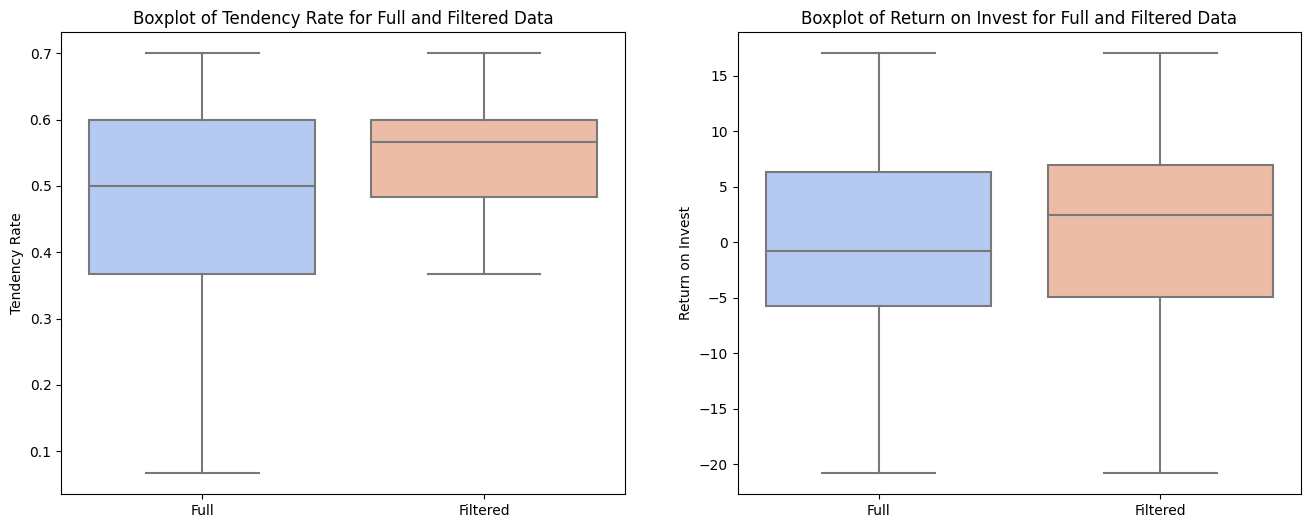

In [69]:
# Combine the 'Tendency Rate' and 'Return on Invest' columns from both DataFrames into a new DataFrame
boxplot_data_tendency = pd.DataFrame({
    'Full': combined_df['Tendency Rate'],
    'Filtered': filtered_df['Tendency Rate']
})

boxplot_data_return = pd.DataFrame({
    'Full': combined_df['Return on Invest'],
    'Filtered': filtered_df['Return on Invest']
})

# Create the combined boxplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(ax=axes[0], data=boxplot_data_tendency, palette='coolwarm')
axes[0].set_ylabel('Tendency Rate')
axes[0].set_title('Boxplot of Tendency Rate for Full and Filtered Data')

sns.boxplot(ax=axes[1], data=boxplot_data_return, palette='coolwarm')
axes[1].set_ylabel('Return on Invest')
axes[1].set_title('Boxplot of Return on Invest for Full and Filtered Data')

plt.show()

ttest for tendency rates between both groups

In [41]:
# Perform the t-test
t_stat, p_value = ttest_ind(combined_df['Tendency Rate'], filtered_df['Tendency Rate'], equal_var=False, nan_policy='omit')

# Print the results
print("T-statistic:", t_stat)
print("P-value:", p_value)

# Test the null hypothesis
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between the Tendency Rates (reject the null hypothesis).")
else:
    print("There is no significant difference between the Tendency Rates (fail to reject the null hypothesis).")

T-statistic: -1.8453877581017697
P-value: 0.07163199146853762
There is no significant difference between the Tendency Rates (fail to reject the null hypothesis).


ttest for return on invest between both groups

In [70]:
# Perform the t-test
t_stat, p_value = ttest_ind(combined_df['Return on Invest'], filtered_df['Return on Invest'], equal_var=False, nan_policy='omit')

# Print the results
print("T-statistic:", t_stat)
print("P-value:", p_value)

# Test the null hypothesis
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between the Tendency Rates (reject the null hypothesis).")
else:
    print("There is no significant difference between the Tendency Rates (fail to reject the null hypothesis).")

T-statistic: -0.5577353818029899
P-value: 0.5801877040294666
There is no significant difference between the Tendency Rates (fail to reject the null hypothesis).
